# Distributed Memory
> Random Features enable Dense Associative Memory to store patterns in a distributed manner across a large number of neurons.

<a target="_blank" href="https://colab.research.google.com/github/bhoov/amtutorial/blob/main/tutorial_ipynbs/03_distributed_memory.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#| hide
# Uncomment to download dependencies to colab
# !pip install amtutorial

In this notebook, we demonstrate how we utilize random features to disentangle the size of the Dense Associative Memory network from the number of memories to be stored. Given the standard log-sum-exp energy $E_\beta(\cdot; \boldsymbol{\Xi})$, corresponding to a model $f_\boldsymbol{\Xi}$ of size $O(DK)$, we demonstrate how we can use the trigonometric random features to develop an approximate energy $\tilde{E}_\beta(\cdot; \mathbf{T})$ using a distributed representation $\mathbf{T}$ of the memories $\boldsymbol{\Xi} = \{ \boldsymbol{\xi}^\mu, \mu \in [\![ K ]\!] \}$, thus giving us a model $f_{\mathbf{T}}$ of size $O(Y)$.

For further details on this work, please see @hoover2024dense.

In [2]:
#| hide
import jax
import jax.numpy as jnp
from jaxtyping import (
    Float, Array, PyTree, jaxtyped, UInt, Bool
)
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from typing import *
from tqdm import tqdm, trange
from itertools import product

In [3]:
#\ hide
#\ output: false
rng = jr.PRNGKey(779)
ngenerators = 10
rnglist = jr.split(rng, ngenerators)

In [4]:
#\ hide
# Color setting for the plots
HMA = 0.8
CMAP = 'coolwarm'
CMAP = 'PiYG_r'
TQDMCOLOR = 'MAGENTA'
MCOLOR = 'xkcd:black'
QCOLOR = 'xkcd:bright blue'
AQCOLOR = 'xkcd:burnt orange'

In [5]:
#\ hide
# Function the 2D energy landscape
def plot_energy_landscape(
    energies,
    plt_ax,
    bounds,
    colormap=CMAP,
    heatmap_alpha=HMA,
):
    assert energies.shape[0] == energies.shape[1]
    plt_ax.imshow(
        energies, extent=bounds,
        origin='lower', cmap=colormap,
        alpha=heatmap_alpha,
    )
    plt_ax.tick_params(
        axis='both', which='both', 
        top=False, bottom=False, 
        labelbottom=False, 
        labelleft=False, 
        left=False, right=False
    )

In [6]:
#\ hide
# Function to plot the states/memories
# in the 2D energy landscape 
def plot_states(
    states,
    plt_ax,
    marker,
    color,
):
    assert states.shape[1] == 2
    plt_ax.scatter(
        states[:, 0], states[:, 1],
        marker=marker, color=color,
    )

In [7]:
#\ hide
# Function to plot the energy descent
# with the number of steps/layers
def plot_energy_descent(
    energies,
    plt_ax,
    color='xkcd:slate'
):
    plt_ax.plot(
        np.arange(energies.shape[0]),
        energies,
        color=color
    )
    plt_ax.set_xlabel(r"$T$")
    plt_ax.set_ylabel('Energy') 

## Exact Energy Function

Consider a set of memories $\boldsymbol{\Xi} = \{ \boldsymbol{\xi}^1, \ldots, \boldsymbol{\xi}^K \}$ where each memory $\boldsymbol{\xi}^\mu \in \mathbb{R}^D$ is a vector in a $D$-dimensional Euclidean space. For a state vector $\mathbf{v} \in \mathbb{R}^D$, the commonly used _log-sum-exp_ energy is given by
$$
E_\beta( \mathbf{v}; \boldsymbol{\Xi} ) = - \frac{1}{\beta} \log \sum_{\mu = 1}^K \exp \left(- \frac{\beta}{2} \left\Vert \mathbf{v} - \boldsymbol{\xi}^\mu \right \Vert^2 \right),
$${#eq-l2-lse-energy}

where $\beta > 0$ is the _inverse-temperature_ controlling the sharpness of the energy near the memories, with larger values of $\beta$ implying sharper energy landscapes, while smaller values induce smoother ones.

We can implement this energy function as follows

In [8]:
def lse_energy(
    state: Float[Array, "D"],
    memories: Float[Array, "K D"],
    beta: float
) -> Float[Array, ""]:
    """
    Compute the standard log-sum-exp energy
    using the negative square Euclidean distance
    as the similarity
    """
    return -(1 / beta) * jax.nn.logsumexp(
        -beta / 2 * ((state - memories) ** 2).sum(-1),
        axis=0
    )


### Visualizing the Energy in 2D

In [9]:
#\ hide
# Here we define the domain, and
# generate grid points from the domain
# to visualize energy landscapes
maxabs = 5
xmin, xmax = ymin, ymax = -maxabs, maxabs
nsteps = 50
gpts = jnp.linspace(xmin, xmax, nsteps)
V = jnp.array(jnp.meshgrid(gpts, gpts))

First we randomly generate $K=8$ memories $\boldsymbol{\Xi} = \{ \boldsymbol{\xi}^\mu, \mu = 1, \ldots, 8 \}$ in $D=2$ dimensions.

In [10]:
# Randomly generate memories in 
# the selected domain
rngidx = 0
D = 2
K = 8
Xi = jr.uniform(
    rnglist[rngidx], (K, D)
) * 2 * maxabs - maxabs

Given this set $\boldsymbol{\Xi}$ of memories, we compute and visualize the 2D energy landscape defined by @eq-l2-lse-energy for varying values of the inverse-temperature $\beta \in \{10^{-2}, 10^{-1}, 1, 10 \}$. We also highlight the $K = 8$ memories on these landscapes with the $\boldsymbol{\star}$ symbol. We will also cache the energy landscapes for future visualizations. 

100%|███████████████| 4/4 [00:04<00:00,  1.24s/it]


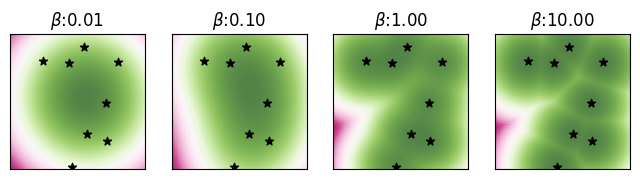

In [11]:
betas = [0.01, 0.1, 1, 10]
figscaler = 2
fig, axs = plt.subplots(
    1, len(betas), figsize=(
        len(betas) * figscaler, 
        figscaler
    ),
    sharex=True, sharey=True
)
beta_en_cache = {}
for b, ax in tqdm(
    zip(betas, axs), total=len(betas),
    colour=TQDMCOLOR, ncols=50
):
    en = np.zeros_like(V[0])
    for i, j in product(
        range(nsteps),
        range(nsteps)
    ):
        en[i,j] = lse_energy(
            V[:, i, j], Xi, b
        )
    beta_en_cache[b] = en
    plot_energy_landscape(
        en, ax, np.array([
            xmin, xmax, ymin, ymax
        ])
    )
    plot_states(
        Xi, ax, marker='*', color=MCOLOR
    )
    ax.set_title(
        r"$\beta$" + f":{b:0.2f}"
    )
plt.show()

### Minimizing the Energy via Gradient Descent 

For an initial state vector $\mathbf{q} \in \mathbb{R}^D$, we can minimize its energy utilizing the energy gradient. Initializing the energy descent at the $\mathbf{q}$, that is $\mathbf{v}^{(0)} \gets \mathbf{q}$, we perform the following gradient descent steps for $T$ iterations:
$$
\mathbf{v}^{(t)} \gets \mathbf{v}^{(t-1)} - \alpha \nabla_{\mathbf{v}} E_\beta( \mathbf{v}^{(t-1)}; \boldsymbol{\Xi} ), 
$$
for $t = 1, \ldots, T$ with $\alpha > 0$ as the step-size (or learning rate) for the energy descent. The final $\mathbf{v}^{(T)}$ is the output of the model.

We can implement this using auto-differentiation in JAX by computing the gradient of the `lse_energy` function with respect to its input `state`.

In [12]:
def lse_energy_descent( 
    q: Float[Array, "D"],
    memories: Float[Array, "K D"],
    beta,
    energy_fn,
    depth: int=10,
    alpha: float = 0.01,
    return_grads=False,
    clamp_idxs: Optional[Bool[Array, "D"]]=None
) -> Float[Array, "D"]: 
    """
    Energy descent with the LSE energy
    """
    dEdxf = jax.jit(
        jax.value_and_grad(energy_fn)
    )
    logs = {}
    def step(x, i):
        E, dEdx = dEdxf(x, memories, beta)
        if clamp_idxs is not None:
            dEdx = jnp.where(clamp_idxs, 0, dEdx)
        x = x - alpha * dEdx
        aux = (E, dEdx) if return_grads else (E,)
        return x, aux
    x, aux = jax.lax.scan(
        step, q, jnp.arange(depth)
    )
    logs['energies'] = aux[0]
    if return_grads:
        logs['grads'] = aux[1]
    return x, logs

#### Energy Descent with the LSE Energy

As an example, we will use the previous set of memories to perform the energy descent for a randomly generated query $\mathbf{q} \in \mathbb{R}^D$ using the above function `lse_energy_descent`. We will note the intermediate states $\mathbf{v}^{(0)}, \ldots, \mathbf{v}^{(T)}$, and the energy $E_\beta(\mathbf{v}^{(t)}; \boldsymbol{\Xi}), t \in [\![ T ]\!]$ at each layer of the DenseAM (equivalently, the energy at each iteration of the energy gradient descent).

In the following example, the number of DenseAM layers (equivalently, the number of energy descent steps) is set at $T = 1000$, and we use a step-size $\alpha = 0.01$. We will plot the intermediate states at every `NUPDATES=25` layers. We show results for three randomly generated queries, where the first row of the plot visualizes their intermediate states of these three queries during the energy descent with the $\textcolor{blue}{\bullet}$ symbol, while the next three rows visualize their respective energy descent through the $T$ DenseAM layers. We will cache the intermediate states and energies of the exact energy descent for future visualizations.

100%|███████████████| 4/4 [00:14<00:00,  3.55s/it]


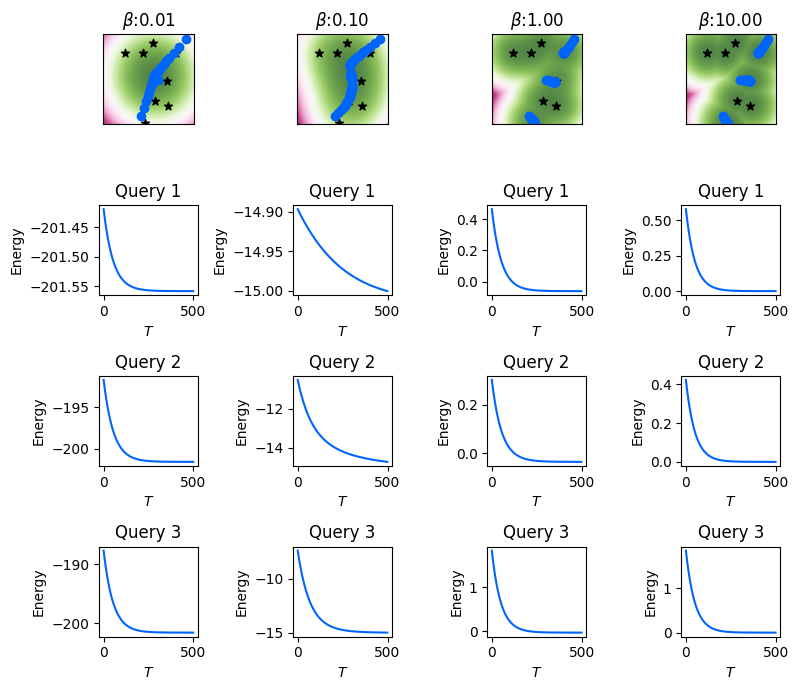

In [13]:
NSTATES = 20
NUPDATES = 25
NQUERIES = 3
ALPHA = 0.01
rngidx = 8
fig, axs = plt.subplots(
    NQUERIES+1, len(betas), figsize=(
        len(betas) * figscaler, 
        NQUERIES+2 * figscaler
    ),
    sharex="row",
)
beta_true_states_en_cache = {}
for bidx, b in tqdm(
    enumerate(betas), total=len(betas),
    colour=TQDMCOLOR, ncols=50
):
    plot_energy_landscape(
        beta_en_cache[b], axs[0, bidx],
        np.array([xmin, xmax, ymin, ymax])
    )
    plot_states(
        Xi, axs[0, bidx],
        marker='*', color=MCOLOR
    )
    axs[0, bidx].set_title(
        r"$\beta$" + f":{b:0.2f}"
    )
    # Randomly generating queries
    queries = jr.uniform(
        rnglist[rngidx], (NQUERIES, D)
    ) * 2 * maxabs - maxabs
    beta_cache = []
    for qidx, query in enumerate(queries):
        qstates = [query]
        qens = []
        # Perform energy descent
        for i in range(NSTATES):
            query, logs = lse_energy_descent(
                query, Xi, b, lse_energy,
                depth=NUPDATES, alpha=ALPHA
            )
            qstates += [query]
            qens += [logs['energies']]
        qstates = np.array(qstates)
        plot_states(
            qstates, axs[0, bidx],
            marker='o', color=QCOLOR
        )
        qens = np.array(qens).reshape(-1)
        plot_energy_descent(
            qens, axs[qidx+1, bidx],
            color=QCOLOR
        )
        axs[qidx+1, bidx].set_title(
            f"Query {qidx+1}"
        )
        beta_cache += [(qstates, qens)]
    beta_true_states_en_cache[b] = beta_cache
fig.tight_layout()
plt.show()

## Viewing Energy as a Kernel Sum

It is easy to see that the aforemention energy function @eq-l2-lse-energy can be viewed as a _kernel sum_. Specifying a kernel function $\kappa: \mathbb{R}^D \times \mathbb{R}^D \to \mathbb{R}$ such that $\kappa(\mathbf{x}, \mathbf{x}') = \exp(-\frac{1}{2} \Vert \mathbf{x} - \mathbf{x}' \Vert^2 )$, the _radial basis function_ or RBF kernel, we can reduce the energy function to a kernel sum as follows:

\begin{align}
E_\beta( \mathbf{v}; \boldsymbol{\Xi} ) 
& = - \frac{1}{\beta} \log \sum_{\mu = 1}^K \underbrace{
  \exp \left(- \frac{\beta}{2} \left\Vert \mathbf{v} - \boldsymbol{\xi}^\mu \right \Vert^2 \right)
}_{\kappa(\sqrt{\beta}\mathbf{v}, \sqrt{\beta}\boldsymbol{\xi}^\mu)}
\\ 
& = - \frac{1}{\beta} \log \sum_{\mu = 1}^K \kappa \left(\sqrt{\beta}\mathbf{v}, \sqrt{\beta}\boldsymbol{\xi}^\mu \right),
\end{align}

In general, we need to keep around all the memories $\boldsymbol{\Xi} = \left\{ \boldsymbol{\xi}^\mu \in \mathbb{R}^D, \mu \in [\![ K ]\!] \right\}$ to compute this kernel sum, and thus the energy function. 

### Simplifying the Kernel Sum with Random Features

However, if there exists a feature map $\Phi: \mathbb{R}^D \to \mathbb{R}^Y$, such that, the dot-product in this feature space approximates the kernel function as follows: 

$$
\kappa(\mathbf{x}, \mathbf{x}') \approx \left\langle \Phi(\mathbf{x}), \Phi(\mathbf{x}') \right\rangle,
$$

then the kernel sum can be simplified as (dropping the $\beta$ for now)

\begin{align}
\sum_{\mu = 1}^K \kappa(\mathbf{v}, \boldsymbol{\xi}^\mu) 
& \approx \sum_{\mu = 1}^K \left\langle \Phi(\mathbf{v}), \Phi(\boldsymbol{\xi}^\mu) \right\rangle
\\
& = \left\langle \Phi(\mathbf{v}), \sum_{\mu = 1}^K \Phi(\boldsymbol{\xi}^\mu) \right\rangle
\\
& = \left\langle \Phi(\mathbf{v}), \mathbf{T} \right\rangle, \qquad \text{where} \quad 
\mathbf{T} = \sum_{\mu = 1}^K \Phi(\boldsymbol{\xi}^\mu).
\end{align}

In this case, we need to compute the vector -- _the distributed memories_ -- $\mathbf{T} \in \mathbb{R}^Y$ using all the $K$ memories $\left\{ \boldsymbol{\xi}^\mu, \mu \in [\![ K ]\!] \right\}$ **just once**, and then use $\mathbf{T}$ for all subsequent kernel sum approximation without needing access to the original memories. Bringing the inverse-temperature $\beta$ into this, we would instead need to utilize $\Phi(\sqrt{\beta}\mathbf{v})$, and compute the distributed memories as $\mathbf{T} = \sum_\mu \Phi(\sqrt{\beta} \boldsymbol{\xi}^\mu)$.

### Examples of Random Features

Various approximate feature maps have been developed for the RBF kernel. The first feature map proposed by @rahimi2007random utilizes random features and trigonometric function. More recently, @choromanski2020rethinking have proposed positive random features utilizing the exponential function. Both these random features are presented below, where $\mathcal{N}(0, \mathbf{I}_D)$ is the $D$-dimensional multivariate isotropic standard normal distribution:

$$
\Phi(\mathbf{x}) = \frac{1}{\sqrt{Y}} \left[ \begin{array}{c}
  \cos \langle \boldsymbol{\omega}^1, \mathbf{x} \rangle \\
  \sin \langle \boldsymbol{\omega}^1, \mathbf{x} \rangle \\
  \cos \langle \boldsymbol{\omega}^2, \mathbf{x} \rangle \\
  \sin \langle \boldsymbol{\omega}^2, \mathbf{x} \rangle \\
  \cdots \\
  \cos \langle \boldsymbol{\omega}^Y, \mathbf{x} \rangle \\
  \sin \langle \boldsymbol{\omega}^Y, \mathbf{x} \rangle \\
\end{array}\right], 
\qquad 
\Phi(\mathbf{x}) = \frac{\exp(- \left\Vert \mathbf{x} \right\Vert^2)}{\sqrt{2Y}} \left[ \begin{array}{c}
  \exp (+\langle \boldsymbol{\omega}^1, \mathbf{x} \rangle) \\
  \exp (-\langle \boldsymbol{\omega}^1, \mathbf{x} \rangle) \\
  \exp (+\langle \boldsymbol{\omega}^2, \mathbf{x} \rangle) \\
  \exp (-\langle \boldsymbol{\omega}^2, \mathbf{x} \rangle) \\
  \cdots \\
  \exp (+\langle \boldsymbol{\omega}^Y, \mathbf{x} \rangle) \\
  \exp (-\langle \boldsymbol{\omega}^Y, \mathbf{x} \rangle) \\
\end{array}\right], 
\quad
\boldsymbol{\omega}^i \sim \mathcal{N}(0, \mathbf{I}_D), i \in [\![ Y ]\!].
$$

Note that both these random features generate $2Y$-dimensional feature map $\Phi(\mathbf{x}) \in \mathbb{R}^{2Y}$ with $Y$ random features $\boldsymbol{\omega}^i, i \in [\![ Y ]\!]$. We implement the random features with trigonometric functions below.

In [14]:
def sin_cos_phi(
    x: Float[Array, "... D"],
    RF: Float[Array, "Y D"],
    beta: float
) -> Float[Array, "... 2Y"]:
    """
    Random features with trigonometric function
    """
    Y = RF.shape[0]
    h = jnp.sqrt(beta) * (x @ RF.T)
    return 1 / jnp.sqrt(Y) * jnp.concatenate(
        [ jnp.cos(h), jnp.sin(h)], axis=-1
    )

#### Approximating the Kernel Value

Here we will visualize the quality of the kernel value approximations obtained with the trigonometric random features. We randomly generate samples $\mathbf{x} \in \mathbb{R}^D$ from the domain, and compare their kernel values with the memories $\boldsymbol{\xi}^\mu$. That is, we compare the true RBF kernel value $\kappa(\sqrt{\beta}\mathbf{x}, \sqrt{\beta}\boldsymbol{\xi}^\mu) = \exp(-\frac{\beta}{2} \Vert \mathbf{x} - \boldsymbol{\xi}^\mu \Vert^2)$ to approximated kernel value using the random features $\left\langle \Phi(\sqrt{\beta}\mathbf{x}), \sqrt{\beta}\Phi(\boldsymbol{\xi}^\mu) \right\rangle$ for different values of $\beta$, $\mu \in [\![ K ]\!]$ and different random samples $\mathbf{x}$.

In the following, we compute the RBF kernel $\kappa(\sqrt{\beta}\mathbf{x}, \sqrt{\beta}\boldsymbol{\xi}^\mu) = \exp(-\frac{\beta}{2} \Vert \mathbf{x} - \boldsymbol{\xi}^\mu \Vert^2)$.

In [15]:
def rbfkernel(
    x: Float[Array, "D"],
    y: Float[Array, "D"],
    beta: float,
) -> Float[Array, ""]:
    """
    Compute the standard RBF kernel
    between two vectors.
    """
    return jnp.exp(
        -0.5 * beta * ((x - y) ** 2).sum()
    )

We generate $Y=2^{15}$ random features for the memories $\boldsymbol{\Xi}$ using the `sin_cos_phi` function.

In [16]:
Y = np.power(2, 15)
rngidx = 4
RF = jr.normal(rnglist[rngidx], (Y, D))
phi_Xi = sin_cos_phi(Xi, RF, 1.0)

Now we generate `NRANDS=100` random $\mathbf{x} \in \mathbb{R}^D$ and compare their exact and approximate kernel values with the memories.

100%|███████████████| 4/4 [00:01<00:00,  3.32it/s]


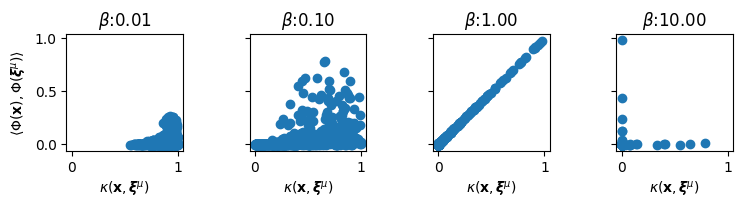

In [17]:
rngidx = 9
NRANDS = 100
rxs = jr.uniform(
    rnglist[rngidx], (NRANDS, D)
) * 2 * maxabs - maxabs

fig, axs = plt.subplots(
    1, len(betas), figsize=(
        len(betas) * figscaler, 
        figscaler
    ),
    sharex=True, sharey=True
)
for b, ax in tqdm(
    zip(betas, axs), total=len(betas),
    colour=TQDMCOLOR, ncols=50
):
    phi_rxs = sin_cos_phi(rxs, RF, b)
    true_kvals = np.array([
        rbfkernel(x, y, b)
        for x in rxs for y in Xi
    ])
    approx_kvals = np.array([
        x.dot(y) 
        for x in phi_rxs for y in phi_Xi
    ])
    ax.scatter(true_kvals, approx_kvals)
    ax.set_xlabel(
        r"$\kappa(\mathbf{x},$" 
        + r"$\boldsymbol{\xi}^\mu)$"
    )
    ax.set_title(r"$\beta$" + f":{b:0.2f}")
    ax.axis('square')
axs[0].set_ylabel(
    r"$\langle \Phi(\mathbf{x}),$" 
    + r"$\Phi(\boldsymbol{\xi}^\mu) \rangle$"
)
fig.tight_layout()
plt.show()

In the above figure, a good approximation would put all the points in the scatter plots on the diagonal. Based on these figures, we make the following observations with a fixed value of $D, Y$:
- Small values of $\beta$ push the RBF kernel values close to 1, and the random features do not approximate these values well, generally significantly underestimating the kernel values as all the points in the scatter plots concentrate in the lower corner.
- As $\beta$ grows, the approximation quality improves, with $\beta = 1$ producing really good approximation of the exact kernel values. The true kernel values better span the range of $[0, 1]$ and the random features produce high quality approximations. 
- When $\beta$ increases beyond a point, most pairwise RBF kernel values go close to zero, and approximation quality again falls.

Note that overall performance will continue to improve as the ratio $D/Y$ decreases for any given value of $\beta$. But it is a known issue that the trigonometric random features do not approximate kernel values close to zero or close to one very well.

#### Visualizing the Random Features

Here we visualize the first `NRFS=6` of the random features across the data domain for varying values of $\beta$. The use of the trigonometric function is visible through the periodic nature of these random features, where larger values of $\beta$ lead to shorter periods.

100%|███████████████| 4/4 [00:00<00:00,  7.03it/s]


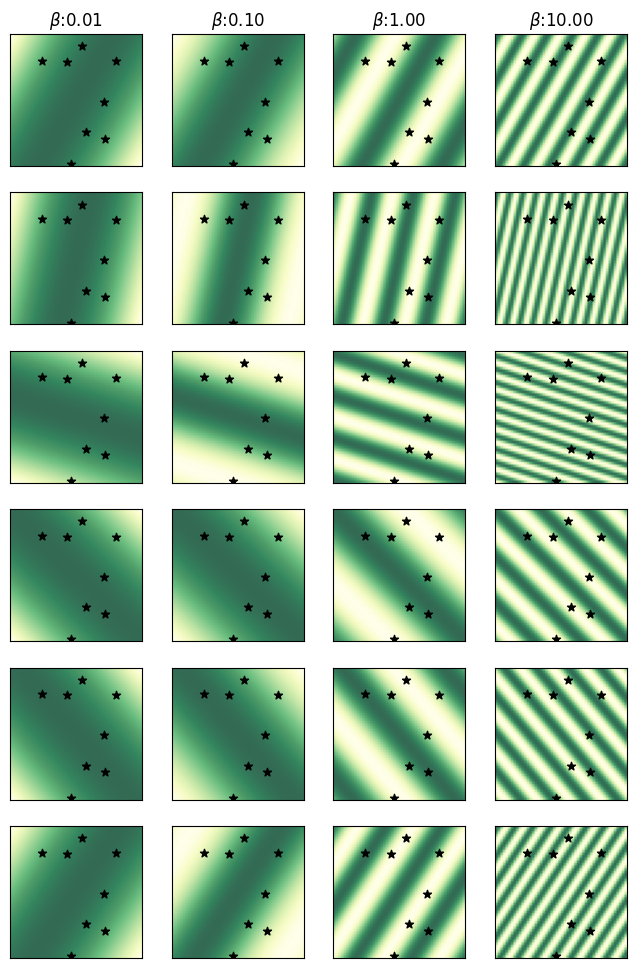

In [18]:
NRFS = 6
fig, axs = plt.subplots(
    NRFS, len(betas), figsize=(
        len(betas) * figscaler, 
        NRFS * figscaler
    ),
    sharex=True, sharey=True
)
for bidx, b in tqdm(
    enumerate(betas),
    total=len(betas),
    colour=TQDMCOLOR,
    ncols=50
):
    rfs = np.zeros(
        [2*NRFS, V.shape[1], V.shape[2]]
    )
    for i in range(nsteps):
        rfs[:, i, :] = sin_cos_phi(
            V[:, i, :].T, RF[:NRFS, :], b
        ).T
    for i in range(NRFS):
        plot_energy_landscape(
            rfs[i, :, :], axs[i, bidx], 
            np.array([
                xmin, xmax, ymin, ymax
            ]),
            colormap='YlGn'
        )
        plot_states(
            Xi, axs[i, bidx],
            marker='*', color=MCOLOR)
    axs[0, bidx].set_title(
        r"$\beta$" + f":{b:0.2f}"
    )
plt.show()

## Approximating the Energy with Random Features

Given the random features $\Phi: \mathbb{R}^D \to \mathbb{R}^{2Y}$, we can approximate the energy as
\begin{align}
E_\beta( \mathbf{v}; \boldsymbol{\Xi} ) 
& = - \frac{1}{\beta} \log \sum_{\mu = 1}^K
  \exp \left(- \frac{\beta}{2} \left\Vert \mathbf{v} - \boldsymbol{\xi}^\mu \right \Vert^2 \right)
\\
& \approx - \frac{1}{\beta} \log \sum_{\mu = 1}^K \left\langle \Phi(\mathbf{v}), \Phi(\boldsymbol{\xi}^\mu) \right\rangle
= - \frac{1}{\beta} \log \left\langle \Phi(\mathbf{v}), \sum_{\mu = 1}^K \Phi(\boldsymbol{\xi}^\mu) \right\rangle
\\
& = - \frac{1}{\beta} \log \left\langle \Phi(\mathbf{v}), \mathbf{T} \right\rangle
= \tilde{E}_\beta(\mathbf{v}, \mathbf{T}), \qquad \text{with} \quad 
\mathbf{T} = \sum_{\mu = 1}^K \Phi(\boldsymbol{\xi}^\mu).
\end{align}{#eq-l2-lse-rf-energy}

We implement this approximate energy below using random features below given the $\{ \boldsymbol{\omega}^i, i \in [\![ Y ]\!] \}$ and the distributed memories $\mathbf{T} \in \mathbb{R}^{2Y}$.


In [19]:
def approx_lse_energy(
    state: Float[Array, "... D"],
    RF: Float[Array, "Y D"],
    beta: float,
    T: Float[Array, "2Y"],
    eps=1e-10
) -> Float[Array, "..."]:
    """
    Compute the approx energy with
    random features
    """
    h = sin_cos_phi(state, RF, beta) @ T 
    h = jnp.clip(h,  a_min=eps)
    return -(1 / beta) * jnp.log(h)

Here we compare the exact energy landscape to energy landscape approximated with random features for varying values of $\beta$ given the set of memories $\boldsymbol{\Xi}$. For a given value of $\beta$, we first compute $\mathbf{T} = \sum_{\mu=1}^K \Phi(\sqrt{\beta} \boldsymbol{\xi}^\mu )$, and the use it to compute the approximate energy landscape. 

The first row of the plots show the (cached) true energy landscape, and the second row shows the energy landscape induced by the approximate energy computed using the distributed memories. Note that we highlight the original memories in the first row of the plots with the true energy landscape.

100%|███████████████| 4/4 [00:03<00:00,  1.26it/s]


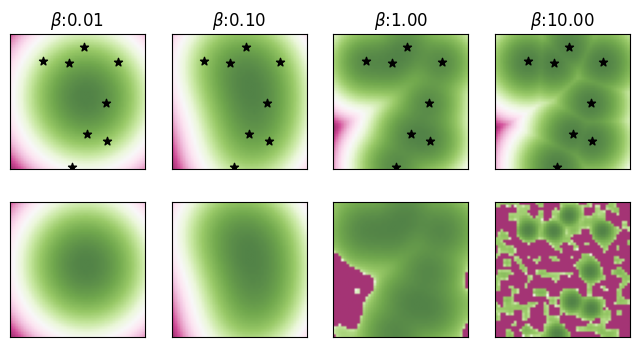

In [20]:
fig, axs = plt.subplots(
    2, len(betas), figsize=(
        len(betas) * figscaler, 
        2 * figscaler
    ),
    sharex=True, sharey=True
)
for bidx, b in tqdm(
    enumerate(betas), total=len(betas),
    colour=TQDMCOLOR, ncols=50
):
    # Computing the T tensor, 
    # summing the random features
    # over all memories
    T_Xi = sin_cos_phi(Xi, RF, b).sum(0)
    # Computing the approx energy 
    # over the domain
    app_en = np.zeros_like(V[0])
    for i in range(nsteps):
        app_en[i, :] = approx_lse_energy(
            V[:, i, :].T, RF, b, T_Xi
        )
    # Plotting the exact and approx energy
    plot_energy_landscape(
        beta_en_cache[b], axs[0, bidx],
        np.array([xmin, xmax, ymin, ymax])
    )
    plot_states(
        Xi, axs[0, bidx],
        marker='*', color=MCOLOR
    )
    plot_energy_landscape(
        app_en, axs[1, bidx],
        np.array([xmin, xmax, ymin, ymax])
    )
    axs[0, bidx].set_title(
        r"$\beta$" + f":{b:0.2f}"
    )
plt.show()

For small values of $\beta$, the exact and approximate energy landscapes appear visually similar. However, for larger values of $\beta$, the energy landscapes start differing significantly, especially farther away from the memories. However, note how the approximate energy still forms a local minima around each of the original memories even though the actual basins of attraction of this approximate energy are significantly smaller. For $\beta = 10$, there are 8 local minima, matching the total number of $K=8$ original memories.

### Approximate Energy Descent

For a state vector $\mathbf{v} \in \mathbb{R}^D$, we can approximately reduce its energy $E_\beta(\mathbf{v}; \boldsymbol{\Xi})$ by utilizing the gradient $\nabla_{\mathbf{v}} \tilde{E}_\beta(\mathbf{v}; \mathbf{T})$ of the random-feature based approximate energy $\tilde{E}_\beta(\mathbf{v}; \mathbf{T})$. Initializing the energy descent at the input $\mathbf{q}$, that is $\tilde{\mathbf{v}}^{(0)} \gets \mathbf{q}$, we perform the following gradient descent steps for $T$ iterations:
$$
\tilde{\mathbf{v}}^{(t)} \gets \tilde{\mathbf{v}}^{(t-1)} - \alpha \nabla_{\mathbf{v}} \tilde{E}_\beta( \tilde{\mathbf{v}}^{(t-1)}; \mathbf{T} ), 
$$
for $t = 1, \ldots, T$ with $\alpha > 0$ as the step-size (or learning rate) for the energy descent. The final $\tilde{\mathbf{v}}^{(T)}$ is the output of this model. This output will be different than the output $\mathbf{v}^{(T)}$ obtained using the exact energy gradient $\nabla_{\mathbf{v}} E_\beta( \mathbf{v}; \boldsymbol{\Xi} )$. 

The gradient of the approximate energy in @eq-l2-lse-rf-energy does not require access to the original memories $\boldsymbol{\Xi}$, and can be computed solely using the random features $\{ \boldsymbol{\omega}^i, i \in [\![ Y ]\!] \}$ and the consolidated memories $\mathbf{T} \in \mathbb{R}^{2Y}$:
$$
\nabla_{\mathbf{v}} \tilde{E}_\beta ( \mathbf{v}; \mathbf{T} ) 
= - \frac{1}{\beta} \nabla_{\mathbf{v}} \log \left\langle \Phi(\mathbf{v}), \mathbf{T} \right\rangle
= - \frac{1}{\beta \left\langle \Phi(\mathbf{v}), \mathbf{T} \right\rangle} \left[ \nabla_{\mathbf{v}} \Phi(\mathbf{v}) \right]^\top \mathbf{T}.
$$
The gradient $\nabla_{\mathbf{v}} \Phi(\mathbf{v})$ of the random feature map $\Phi: \mathbb{R}^D \to \mathbb{R}^{2Y}$ with respect to its input is a $(2Y \times D)$ matrix. 

We can implement this using auto-differentiation in JAX by computing the gradient of the `approx_lse_energy` function with respect to its input `state`.

In [21]:
def approx_lse_energy_descent(
    q: Float[Array, "D"],
    RF: Float[Array, "Y D"],
    beta: float,
    T: Float[Array, "2Y"],
    energy_fn,
    depth: int=10,
    alpha: float = 0.01, 
    return_grads=False,
    clamp_idxs: Optional[Bool[Array, "D"]]=None
) -> Float[Array, "D"]: 
    """
    Using the approx random feature energy.
    run energy descent
    """
    dEdxf = jax.jit(
        jax.value_and_grad(energy_fn)
    )
    logs = {}
    @jax.jit
    def step(x, i):
        E, dEdx = dEdxf(x, RF, beta, T)
        if clamp_idxs is not None:
            dEdx = jnp.where(clamp_idxs, 0, dEdx)
        x = x - alpha * dEdx
        aux = (E, dEdx) if return_grads else (E,)
        return x, aux
    x, aux = jax.lax.scan(
        step, q, jnp.arange(depth)
    )
    logs['energies'] = aux[0]
    if return_grads:
        logs['grads'] = aux[1]
    return x, logs

We will now compare the energy descent dynamics of this gradient using the random-feature based approximate energy to the exact energy gradient from earlier. We keep the step-size $\alpha$ and the number of DenseAM layers $T$ the same as the exact energy descent with $\alpha = 0.01$ and $T = 1000$. For each of the intermediate states obtained with this approximate energy descent, we compute the exact energy to check how it decreases through the distributed-memory DenseAM layers. 

We will use the cached energy landscapes and the cached intermediate states and energies for the exact energy descent to highlight the similarities and differences. The intermediate states for the three queries with exact energy descent will be shown with the $\textcolor{blue}{\bullet}$ symbol, while the intermediate states with the approximate random-features-based energy will be show with the $\textcolor{orange}{\bullet}$ symbol. 

100%|███████████████| 4/4 [00:14<00:00,  3.55s/it]


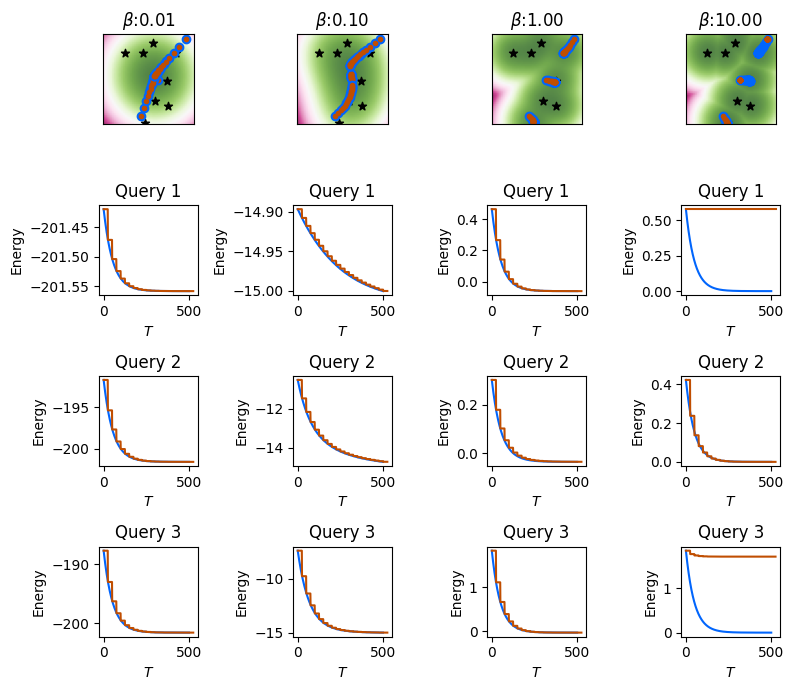

In [22]:
rngidx = 8
fig, axs = plt.subplots(
    NQUERIES+1, len(betas), figsize=(
        len(betas) * figscaler, 
        NQUERIES+2 * figscaler
    ),
    sharex="row",
)
for bidx, b in tqdm(
    enumerate(betas), total=len(betas),
    colour=TQDMCOLOR, ncols=50
):
    # using cached energy landscape
    plot_energy_landscape(
        beta_en_cache[b], axs[0, bidx],
        np.array([xmin, xmax, ymin, ymax])
    )
    plot_states(
        Xi, axs[0, bidx],
        marker='*', color=MCOLOR
    )
    axs[0, bidx].set_title(
        r"$\beta$" + f":{b:0.2f}"
    )
    # Computing the T tensor, 
    # summing the random features
    # over all memories
    T_Xi = sin_cos_phi(Xi, RF, b).sum(0)
    # Randomly generating queries
    queries = jr.uniform(
        rnglist[rngidx], (NQUERIES, D)
    ) * 2 * maxabs - maxabs
    beta_cache = []
    for qidx, query in enumerate(queries):    
        qstates = [query]
        qens = []
        # Perform energy descent using 
        # the approx gradient
        for i in range(NSTATES):
            query, logs = approx_lse_energy_descent(
                query, RF, b, T_Xi, approx_lse_energy,
                depth=NUPDATES, alpha=ALPHA
            )
            qstates += [query]
            qens += [logs['energies']]
        # using cached exact descent stats
        ex_qstates, ex_qens = beta_true_states_en_cache[b][qidx]
        plot_states(
            ex_qstates, axs[0, bidx],
            marker='o', color=QCOLOR
        )
        plot_energy_descent(
            ex_qens, axs[qidx+1, bidx],
            color=QCOLOR
        )
        axs[qidx+1, bidx].set_title(
            f"Query {qidx+1}"
        )
        qstates = np.array(qstates)
        plot_states(
            qstates, axs[0, bidx],
            marker='.', color=AQCOLOR
        )
        qens = np.array([
            [lse_energy(qs, Xi, b)]*NUPDATES
            for qs in qstates
        ]).reshape(-1)
        plot_energy_descent(
            qens, axs[qidx+1, bidx], 
            color=AQCOLOR
        )
fig.tight_layout()
plt.show()

The above results show that, for small to moderately large $\beta$, with sufficiently large number of random features $Y$, the gradient of the random-feature based approximate energy matches the dynamics of the exact energy gradient. See how the $\textcolor{orange}{\bullet}$ symbols for the approximate energy gradient are completely overlapping with $\textcolor{blue}{\bullet}$ symbol for the exact energy descent.   However, for large $\beta$, the gradient of the approximate energy is no longer able to reduce the energy of the initial state if the initial state happens to be quite far from all the memories, implying a large initial energy $E_\beta ( \mathbf{v}^{(0)}; \boldsymbol{\Xi} )$. Note that one or the three queries is able to reduce its energy and match the exact energy descent. 

Our previous results showed that the random-feature based kernel approximation does not perform well if $\beta$ is too small, or too large. However, the approximate kernel based energy gradient is sufficient for low $\beta$ regime, highlighting that energy descent is possible even if the kernel approximation is poor. This is because the energy of the initial state at low $\beta$ is already quite low.  

More precisely, we can bound the divergence between the output of the exact model with memory representation $f_{\boldsymbol{\Xi}}( \mathbf{q} ) = \mathbf{v}^{(T)}$ and the output of the approximate model with distributed representations $f_{\mathbf{T}}( \mathbf{q} ) = \tilde{\mathbf{v}}^{(T)}$ under the following conditions:
- For any $\mathbf{x}, \mathbf{x}' \in \mathbb{R}^D$, there is a universal constant $C_1 > 0$ such that
$$\left| \kappa(\mathbf{x}, \mathbf{x}') - \left\langle \Phi(\mathbf{x}) , \Phi(\mathbf{x}') \right\rangle \right| \leq C_1 \sqrt{\frac{D}{Y}}.$$
- The step-size $\alpha$ is selected, such that, for a universal constant $C_2 \in (0, 1)$
$$ \alpha \leq \frac{C_2}{T (1 + 2K \beta \exp(\beta/2))}.$$

Then the divergence is bounded as [see @hoover2024dense, Corollary 1]:
$$
\left\Vert f_{\boldsymbol{\Xi}}(\mathbf{q}) - f_{\mathbf{T}}(\mathbf{q}) \right\Vert
= \left\Vert \mathbf{v}^{(T)} - \tilde{\mathbf{v}}^{(T)} \right\Vert 
\leq \frac{C_1 C_2 \exp(E_\beta(\mathbf{q}; \boldsymbol{\Xi}) - 1/2)}{\beta (1 - C_2)}
$$

We can also show a more general result without the restriction on the step-size $\alpha$ [see @hoover2024dense, Theorem 1].

### DrDAM class

We can put together **D**istributed **r**epresentation **D**ense**AM** or **DrDAM** into a single class for convenience.

In [23]:
class DrDAM:
    """
    DenseAM through the Lens of Random Features
    """
    def __init__(self, key, D, Y, beta):
        self.RF = jr.normal(key, (Y, D))
        self.beta = beta
        self.Y = Y
        self.Tdim = 2*Y
        self.D = D

    def phi(
        self, x: Float[Array, "... D"]
    ) -> Float[Array, "... 2Y"]:
        """Compute the random features """
        return sin_cos_phi(x, self.RF, self.beta)

    def sim(
        self, x: Float[Array, "D"],
        y: Float[Array, "D"]
    ) -> Float[Array, ""]:
        """
        Compute the exact RBF kernel for two vectors
        """
        return rbfkernel(x, y, self.beta)

    def energy(
        self, x: Float[Array, "D"],
        memories: Float[Array, "M D"]
    ) -> Float[Array, ""]:
        """Compute the standard LSE energy"""
        return lse_energy(x, memories, self.beta)

    def rf_approx_energy(
        self, x: Float[Array, "D"],
        T: Float[Array, "2Y"], eps=1e-10
    ) -> Float[Array, ""]:
        """
        Compute the approx LSE energy with random features
        """
        return approx_lse_energy(x, self.RF, self.beta, T)
    
    def rf_approx_sim(
        self, x: Float[Array, "D"],
        y: Float[Array, "D"]
    ) -> Float[Array, ""]:
        """Compute the approx RBF kernel for two vector"""
        return self.phi(x) @ self.phi(y)

    def dist_memories(
        self, memories: Float[Array, "M D"]
    ) -> Float[Array, "2Y"]:
        """
        Compute the random-feature based distributed
        representation of the memories
        """
        return self.phi(memories).sum(0)

    def energy_descent( 
        self, q: Float[Array, "D"], 
        memories: Float[Array, "M D"], 
        depth: int=1000, alpha: float = 0.1,
        return_grads=False, 
        clamp_idxs: Optional[Bool[Array, "D"]]=None
    ) -> Float[Array, "D"]: 
        """Run exact energy descent"""
        return lse_energy_descent( 
            q, memories, self.beta, lse_energy,
            depth, alpha, return_grads, clamp_idxs
        )

    def rf_approx_energy_descent(
        self, q: Float[Array, "D"],
        T: Float[Array, "2Y"], 
        depth: int=1000, alpha: float = 0.1,
        return_grads=False,
        clamp_idxs: Optional[Bool[Array, "D"]]=None
    ) -> Float[Array, "D"]: 
        """Run approx energy descent"""
        return approx_lse_energy_descent(
            q, self.RF, self.beta, T, approx_lse_energy,
            depth, alpha, return_grads, clamp_idxs
        )

We will demonstrate the use of this class with $K = 20$ memories in $D=10$ dimensions and $Y=10^4$ random features. We will use the LSE energy with an inverse-temperature $\beta=10$. 

In [24]:
rngidx = 9
D = 30
Y = 100_000
n_memories = 20
n_queries = 100
beta = 25
kdam = DrDAM(
    rnglist[rngidx], D=D, Y=Y, beta=beta
)

Comparing the exact and approximate RBF kernel values for a pair of points.

In [25]:
rngidx = 0
xpair = (
    jr.uniform(rnglist[rngidx], (D,2 )) > 0.5
) / jnp.sqrt(D)
print(
    f"Exact RBF kernel value: "
    f"{kdam.sim(xpair[:, 0], xpair[:, 1]):0.4f}"
)
print(
    f"Approx RBF kernel value: "
    f"{kdam.rf_approx_sim(xpair[:, 0], xpair[:, 1]):.04f}"
)

Exact RBF kernel value: 0.0013
Approx RBF kernel value: 0.0030


Generating some memories, and their distribution representation along with some random initial states.

In [26]:
rngidx = 2
memories = (
    jr.uniform(rnglist[rngidx], (n_memories, D)) > 0.5
) / jnp.sqrt(D)
rngidx = 6
queries = (
    jr.uniform(rnglist[rngidx], (n_queries, D)) > 0.5
) / jnp.sqrt(D)
print(
    f"Generated {memories.shape[0]} memories"
    f" in {memories.shape[1]} dimensions"
)
T = kdam.dist_memories(memories)
print(
    f"Distributed representation of "
    f"these memories in {T.shape[0]} dimensions"
)
print(
    f"Generated {queries.shape[0]} initial "
    f"states in {queries.shape[1]} dimensions"
)

Generated 20 memories in 30 dimensions
Distributed representation of these memories in 200000 dimensions
Generated 100 initial states in 30 dimensions


We will compare the exact and the approximate energy using the distributed memory

In [27]:
print(
    f"Exact energy for a point: "
    f"{kdam.energy(xpair[:, 0], memories):0.4f}"
)
print(
    f"Approx energy for the same point: "
    f"{kdam.rf_approx_energy(xpair[:, 0], T):0.4f}"
)

Exact energy for a point: 0.0847
Approx energy for the same point: 0.0886


This is a comparison of the exact and approximate energies of all initial states. Better approximation is denoted by the points on the scatter plot lying on the diagonal.

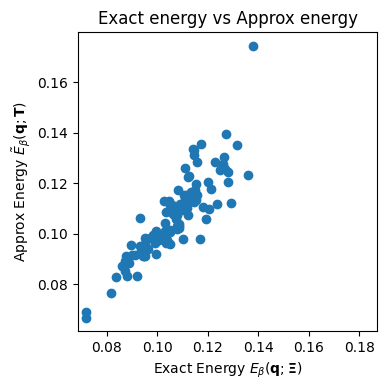

In [28]:
exact_energies = jnp.array([
    kdam.energy(q, memories).item() 
    for q in queries
])
rf_approx_energies = kdam.rf_approx_energy(
    queries, T
)
plt.figure(figsize=(4,4))
plt.scatter(
    exact_energies,
    rf_approx_energies
)
plt.xlabel(
    "Exact Energy " + 
    r"$E_\beta(\mathbf{q}; \boldsymbol{\Xi})$"
)
plt.ylabel(
    "Approx Energy " + 
    r"$\tilde{E}_\beta(\mathbf{q}; \mathbf{T})$"
)
plt.axis('square')
plt.title("Exact energy vs Approx energy")
plt.tight_layout()
plt.show()

For 10 queries, we will perform the inference through a $T=10$ layer DenseAM and compute and report the divergence between the exact energy descent model and the distributed memory DenseAM.

In [29]:
for qidx in range(10):
    exact_out, _ = kdam.energy_descent(
        queries[qidx], memories, depth=10, alpha=0.1
    )
    approx_out, _ = kdam.rf_approx_energy_descent(
        queries[qidx], T, depth=10, alpha=0.1
    )
    print(
        f"Initial state {qidx+1}: "
        f" Initial energy: "
        f"{kdam.energy(queries[qidx], memories):0.4f}, "
        f"Divergence in the output: "
        f"{jnp.sqrt(((exact_out - approx_out)**2).sum()):0.4f}"
    )

Initial state 1:  Initial energy: 0.0950, Divergence in the output: 0.0238
Initial state 2:  Initial energy: 0.1262, Divergence in the output: 0.0269
Initial state 3:  Initial energy: 0.1140, Divergence in the output: 0.0436
Initial state 4:  Initial energy: 0.0997, Divergence in the output: 0.0285
Initial state 5:  Initial energy: 0.1023, Divergence in the output: 0.0306
Initial state 6:  Initial energy: 0.1107, Divergence in the output: 0.0352
Initial state 7:  Initial energy: 0.0991, Divergence in the output: 0.0269
Initial state 8:  Initial energy: 0.1278, Divergence in the output: 0.0383
Initial state 9:  Initial energy: 0.1082, Divergence in the output: 0.0325
Initial state 10:  Initial energy: 0.1035, Divergence in the output: 0.0356
